<a href="https://colab.research.google.com/github/MalcolmSlaney/StanfordAudiology/blob/main/Make_Standard_Clusters_and_Data_Version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Make clusters and process data
Read the data from the official spreadsheets, clean it, computer the HL clusters, and calculate the SII.  Save the cluster results (centroids) and a pickle file that has all the results of this processing.

##Imports

In [1]:
!rm -rf StanfordAudiology

In [2]:
!git clone https://github.com/MalcolmSlaney/StanfordAudiology.git

Cloning into 'StanfordAudiology'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 213 (delta 111), reused 77 (delta 36), pack-reused 24
Receiving objects: 100% (213/213), 98.77 KiB | 1.37 MiB/s, done.
Resolving deltas: 100% (114/114), done.


In [3]:
# Import the packages needed for this Colab.
from collections import Counter
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import sklearn
from typing import Dict, List, Optional, Union

# This next import is needed here to authenticate user for pulling
# spreadsheet data.

import google.colab as colab
from StanfordAudiology import clusters

In [4]:
colab.auth.authenticate_user

<function google.colab.auth.authenticate_user(clear_output=True, project_id=None)>

##Access our Google Drive with the data

In [5]:
# from google.colab import auth
from google.colab import drive
# from oauth2client.client import GoogleCredentials

In [6]:
# Mount my gDrive files
# OR this? https://stackoverflow.com/questions/48376580/how-to-read-data-in-google-colab-from-my-google-drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Create the standard clusters

In [7]:
# These defines allow us to change the Stanford Audiology. Since these are
# symbols defined in the clusters module, they aren't accessible in new versions
# of the functions defined here.  By duplicating these symbols into the current
# package the new code works like the old.

ReadData = clusters.ReadData
MakePandas = clusters.MakePandas
RemoveRowsWithBadAges = clusters.RemoveRowsWithBadAges
HLossClassifier = clusters.HLossClassifier
RemoveRowsWithBCWorseAC = clusters.RemoveRowsWithBCWorseAC
CreateKMeans = clusters.CreateKMeans
CreateClusterLabels = clusters.CreateClusterLabels
KMeansPredictions = clusters.KMeansPredictions
AssignClusterLabels = clusters.AssignClusterLabels
CountPredictions = clusters.CountPredictions
SaveAsJson = clusters.SaveAsJson

duplicate_column_name_v1 = clusters.duplicate_column_name_v1
labels_v1 = clusters.labels_v1
spreadsheet_path_v1 = clusters.spreadsheet_path_v1
default_cluster_dir = clusters.default_cluster_dir
golden_cluster_v1 = clusters.golden_cluster_v1
change_key_values_to_integer = clusters.change_key_values_to_integer

clusters.default_cluster_dir = '/content/gdrive/Shareddrives/StanfordAudiology/ColabNotebooks/'

In [8]:
data_pickle_filename = os.path.join(clusters.default_cluster_dir, 'all_hl_data.pkl')
!rm {data_pickle_filename}

In [9]:
if os.path.exists(data_pickle_filename):
  print(f'Loading standard data from {data_pickle_filename}...')
  saved_data_or_filename = pd.read_pickle(data_pickle_filename)
  print(f'  and it has shape {saved_data_or_filename.shape}')
else:
  saved_data_or_filename = clusters.spreadsheet_path_v1

In [10]:
!ls {clusters.default_cluster_dir}
clusters.default_cluster_dir

Cluster04Way.json  Cluster08Way.json  Cluster12Way.json  Cluster16Way.json  Cluster6Way.json
Cluster05Way.json  Cluster09Way.json  Cluster13Way.json  Cluster17Way.json  Cluster6Way.json.json
Cluster06Way.json  Cluster10Way.json  Cluster14Way.json  Cluster18Way.json  ClustersV1.json
Cluster07Way.json  Cluster11Way.json  Cluster15Way.json  Cluster19Way.json


'/content/gdrive/Shareddrives/StanfordAudiology/ColabNotebooks/'

In [11]:
colab.auth.authenticate_user()

cluster_data_filename, all_data = clusters.CreateClusterV1(
    'ClustersV1',
    save_path=clusters.default_cluster_dir,
    spreadsheet_path=saved_data_or_filename)

Number of rows that have been dropped due to AC/BC differences:  0
all_data has 99 columns


In [12]:
!ls -l {cluster_data_filename}

-rw------- 1 root root 4530 Oct 22 14:12 /content/gdrive/Shareddrives/StanfordAudiology/ColabNotebooks/ClustersV1.json


In [13]:
all_data.shape

(57718, 100)

In [14]:
all_data.columns

Index(['AgeAtTestDate', 'R125', 'R250', 'R500', 'R1000', 'R1500', 'R2000',
       'R3000', 'R4000', 'R6000', 'R8000', 'L125', 'L250', 'L500', 'L1000',
       'L1500', 'L2000', 'L3000', 'L4000', 'L6000', 'L8000', 'RBone125',
       'RBone250', 'RBone500', 'RBone1000', 'RBone1500', 'RBone2000',
       'RBone3000', 'RBone4000', 'RBone6000', 'RBone8000', 'LBone125',
       'LBone250', 'LBone500', 'LBone1000', 'LBone2000', 'LBone2000',
       'LBone3000', 'LBone4000', 'LBone6000', 'LBone8000', 'SRT_R',
       'DateOfTest', 'SRT_L', 'Word_Rec_Score_R', 'Headphones',
       'Word_Rec_Score_L', 'Word_Rec_Level_R', 'Word_Rec_Masking_R',
       'Word_Rec_Masking_L', 'Word_Rec_Level_L', 'TestLocation',
       'WordRecListRight', 'WordRecListLeft', 'MonSNR_Score_R',
       'MonSNR_Score_L', 'MonSNR_Right_Number_Lists', 'MonSNR_Level_R',
       'MonSNR_Left_Number_Lists', 'MonSNR_Level_L', 'TympPressure_L',
       'TympCompliance_L', 'TympType_R', 'TympVolume_L', 'TympVolume_R',
       'TympPressur

In [15]:
clusters.default_cluster_dir

'/content/gdrive/Shareddrives/StanfordAudiology/ColabNotebooks/'

In [16]:
all_data

AgeAtTestDate  R125  R250  R500  R1000  R1500  R2000  R3000  R4000  \
0               58.0   NaN  55.0  60.0   60.0    NaN   60.0   50.0   45.0   
1               37.0   NaN  45.0  40.0   35.0    NaN   50.0   40.0   50.0   
2               25.0   NaN  20.0  15.0   15.0    NaN   15.0   20.0   25.0   
3               49.0   NaN  15.0  15.0   20.0    NaN   10.0    0.0    0.0   
4               47.0   NaN  15.0  15.0   10.0    NaN    5.0   10.0   15.0   
...              ...   ...   ...   ...    ...    ...    ...    ...    ...   
76967           86.0   NaN  75.0  85.0   85.0   80.0   75.0   75.0   70.0   
76968           91.0   NaN  40.0  40.0   50.0   50.0   60.0   75.0   85.0   
76969           40.0   NaN  30.0  25.0   20.0    NaN   15.0   10.0   10.0   
76972           75.0   NaN  20.0  25.0   30.0    NaN   40.0   45.0   55.0   
76976           25.0   NaN  45.0  50.0   45.0   45.0   40.0   70.0   65.0   

       R6000  ...  R_PTA_ABGap  R_HFPTA_ABGap  R_PTA_All_ABGap  L_PTA_ABGap  \
0       50.0  ...    46.666667      36.666666            41.25     5.416666   
1       50.0  ...    25.000002      28.333334            26.25    11.666668   
2       30.0  ...    10.000000       8.333334            10.00    20.833332   
3        0.0  ...    10.000000       6.666667             7.50     3.333333   
4       15.0  ...     1.666667       3.333333             3.75          NaN   
...      ...  ...          ...            ...              ...          ...   
76967   70.0  ...     3.333328       1.666664             2.50    18.333336   
76968   80.0  ...          NaN            NaN              NaN    -1.250000   
76969   10.0  ...     3.333334       0.000000             2.50     0.833334   
76972   60.0  ...          NaN      -8.333332           -12.50     2.500000   
76976   60.0  ...    30.000000      36.666667            36.25     0.833334   

       L_HFPTA_ABGap  L_PTA_All_ABGap  R_Type_HL_Mod  R_Type_HL_HF  \
0           3.750000             6.00     Conductive    Conductive   
1           7.500000            10.00     Conductive    Conductive   
2          16.250000            19.50         Normal        Normal   
3           3.333333             3.75         Normal        Normal   
4           6.666667             8.75         Normal        Normal   
...              ...              ...            ...           ...   
76967      18.333336            17.50           SNHL          SNHL   
76968       1.666668             0.25         Normal        Normal   
76969       2.500000             3.00         Normal        Normal   
76972       7.500000             4.75         Normal          SNHL   
76976       0.416666             1.50     Conductive    Conductive   

       R_Type_HL_All  predictions  
0         Conductive            5  
1         Conductive            5  
2             Normal            1  
3             Normal            2  
4             Normal            2  
...              ...          ...  
76967           SNHL            4  
76968         Normal            0  
76969         Normal            2  
76972           SNHL            3  
76976     Conductive            0  

[57718 rows x 100 columns]

In [17]:
random_state = 0
max_iter = 1000
n_init = 10
ref_cluster = golden_cluster_v1

for n in range(4,21):
  print(f'{n}-way clustering...')
  # Create and apply K-means clustering
  kmeans = clusters.CreateKMeans(n, all_data[clusters.labels_v1], random_state, max_iter, n_init)
  # cluster_labels = CreateClusterLabels(kmeans, ref_cluster)
  cluster_ids = clusters.KMeansPredictions(kmeans, all_data[clusters.labels_v1])
  all_data[f'Cluster{n:02}Way'] = cluster_ids

4-way clustering...
5-way clustering...
6-way clustering...
7-way clustering...
8-way clustering...
9-way clustering...
10-way clustering...
11-way clustering...
12-way clustering...
13-way clustering...
14-way clustering...
15-way clustering...
16-way clustering...
17-way clustering...
18-way clustering...
19-way clustering...
20-way clustering...


In [18]:
CountPredictions(all_data, cluster_field='Cluster20Way')

Counter({7: 1729,
         0: 1728,
         4: 2904,
         12: 7102,
         14: 7427,
         1: 2938,
         10: 1348,
         18: 1806,
         16: 2727,
         17: 3020,
         11: 3994,
         15: 2627,
         13: 2707,
         5: 3259,
         19: 1394,
         8: 3079,
         2: 2119,
         9: 2910,
         3: 941,
         6: 1959})

##Add the Speech Intelligibility Index before saving

In [19]:
!pip install speech_intelligibility_index

In [20]:
from speech_intelligibility_index import sii

In [21]:
default_audiogram_freqs = [125, 250, 500, 750, 1000, 1500, 2000, 3000, 4000, 6000, 8000]

def sii_from_audiogram(
    audiogram_samples: Union[List[float], np.ndarray],
    audiogram_freqs: Union[List[float], np.ndarray] = default_audiogram_freqs) -> float:
    """Compute the speech intelligibility index from an audiogram

    Args:
      audiogram_samples: Hearing loss in db at frequencies corresponding to the
        next argument
      audiogram_freqs: Frequencies (Hz) where audiogram is measured
    Returns:
      a float, the corresponding speech intelligibility index
    """
    audiogram_samples = np.asarray(audiogram_samples)
    audiogram_freqs = np.asarray(audiogram_freqs)
    assert audiogram_samples.ndim == 1
    assert audiogram_freqs.ndim == 1
    assert audiogram_samples.shape[0] == audiogram_freqs.shape[0]

    # Interpolate from the supplied audiogram frequencies to the critical
    interp_func = interpolate.interp1d(audiogram_freqs, audiogram_samples,
                                       kind='quadratic',
                                       fill_value='extrapolate')
    critical_band_hl = interp_func(sii.mid_band_freqs)

    [ssl, nsl, hearing_threshold] = sii.input_5p1(ssl='normal')
    return sii.sii(ssl=ssl, nsl=nsl, hearing_threshold=critical_band_hl)

In [22]:
audiogram_freqs = [int(f[1:]) for f in clusters.labels_v1]
audiogram_freqs

[250, 500, 1000, 2000, 3000, 4000, 6000, 8000]

In [23]:
all_siis = []
hl_thresholds = all_data[clusters.labels_v1].values

for i in range(hl_thresholds.shape[0]):
  all_siis.append(sii_from_audiogram(hl_thresholds[i, :], audiogram_freqs))

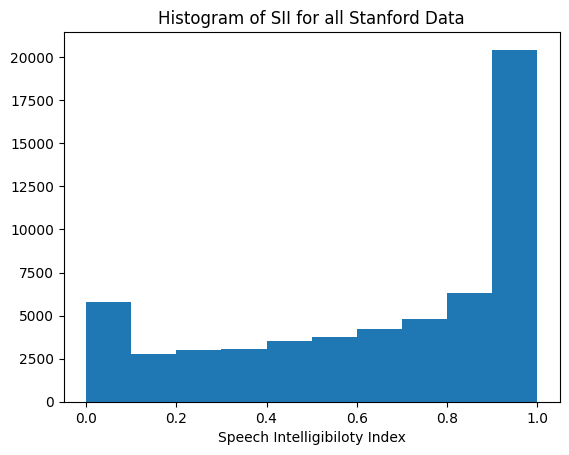

In [24]:
plt.hist(all_siis)
plt.xlabel('Speech Intelligibiloty Index')
plt.title('Histogram of SII for all Stanford Data');

In [25]:
all_data['sii_estimate'] = all_siis

##Save the whole data set for easier retrieval

In [26]:
all_data.columns

Index(['AgeAtTestDate', 'R125', 'R250', 'R500', 'R1000', 'R1500', 'R2000',
       'R3000', 'R4000', 'R6000',
       ...
       'Cluster12Way', 'Cluster13Way', 'Cluster14Way', 'Cluster15Way',
       'Cluster16Way', 'Cluster17Way', 'Cluster18Way', 'Cluster19Way',
       'Cluster20Way', 'sii_estimate'],
      dtype='object', length=118)

In [27]:
data_pickle_filename = os.path.join(clusters.default_cluster_dir, 'all_hl_data.pkl')
all_data.to_pickle(data_pickle_filename)

print(f'All HL data, cluster classifictions, and SII are at {data_pickle_filename}')

All HL data, cluster classifictions, and SII are at /content/gdrive/Shareddrives/StanfordAudiology/ColabNotebooks/all_hl_data.pkl


##Load and display cluster data

In [28]:
kmeans_6, feature_labels_6, all_features6 = clusters.LoadFromJson(cluster_data_filename)

In [29]:
kmeans_6

KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=0)

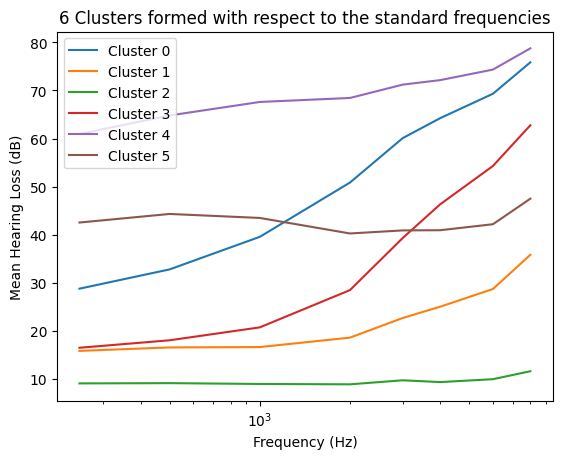

In [30]:
clusters.PlotClusterCenters(feature_labels_6, kmeans_6, None, 6)